In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from umap import plot

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')

/Users/wangqiqian/Desktop/TrafficTDApython


/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/wangqi

In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 3]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

22


In [4]:
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]

rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

(65306, 185)


n_neighbors越大越注重全局結構，5 到 50 ，5~15適合高維度<br/>
min_dist影響緊密程度，越大越稀疏，通常在0.0 到 0.5

In [ ]:
# n_neighbors_range = range(5, 21, 5)  # 5 to 20 inclusive
n_neighbors = 100
min_dist_range = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # 0.1 to 0.5 inclusive with 5 steps

# for n_neighbors in n_neighbors_range:
for min_dist in min_dist_range:
    
    start_time = time.time()

    reducer = umap.UMAP(
        n_jobs=-1, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        n_components=10, 
        metric="hamming")

    lens1_umap = reducer.fit_transform(mapper_numpy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(elapsed_time)

    # 將嵌入結果轉換為 DataFrame
    embedding_df = pd.DataFrame(lens1_umap, columns=[f'UMAP{i}' for i in range(1, lens1_umap.shape[1]+1)])
    embedding_df['label'] = dummy_data['死亡']

    # 視覺化結果
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='label',  # 以 label 分類顏色
        palette='tab10',  # 色盤
        data=embedding_df,
        legend='full',
        alpha=0.8
    )
    plt.title('UMAP Projection of the Dataset')

    # Save plot
    plot_path = os.path.join("Version3/GridSearch/UMAP/hamming", f"UMAP_n{n_neighbors}_d{min_dist:.2f}.png")
    plt.savefig(plot_path)
    plt.close()

In [7]:
start_time = time.time()

reducer = umap.UMAP(
    n_jobs=-1, 
    n_neighbors=80,
    min_dist=0.8, 
    n_components=5, 
    metric="hamming")

lens1 = reducer.fit_transform(mapper_numpy)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


157.39633798599243


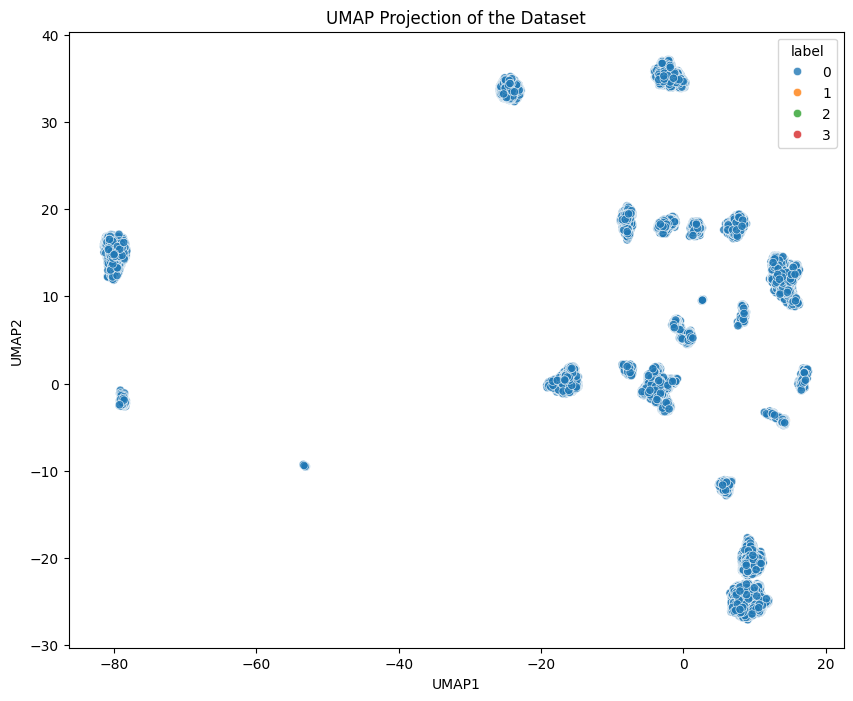

In [8]:
# 將嵌入結果轉換為 DataFrame
embedding_df = pd.DataFrame(lens1, columns=[f'UMAP{i}' for i in range(1, lens1.shape[1]+1)])
embedding_df['label'] = dummy_data['死亡']

# 視覺化結果
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='label',  # 以 label 分類顏色
    palette='tab10',  # 色盤
    data=embedding_df,
    legend='full',
    alpha=0.8
)
plt.title('UMAP Projection of the Dataset')
plt.show()

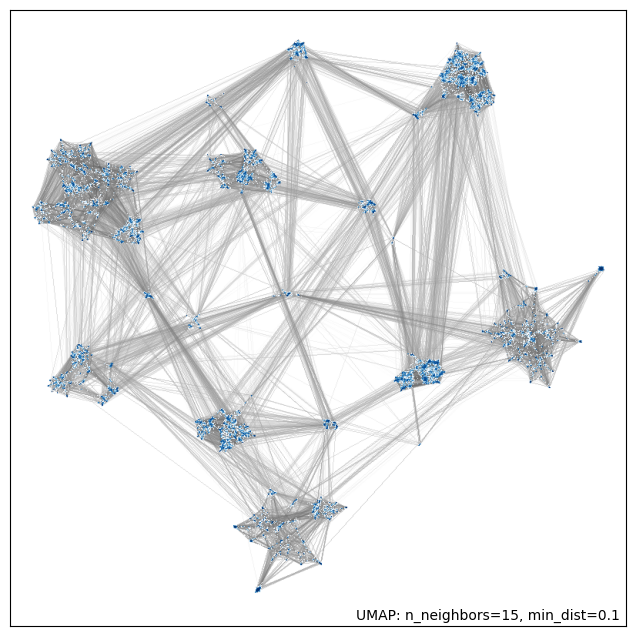

In [7]:
mapping = umap.UMAP().fit(mapper_numpy)

umap_plot = umap.plot.connectivity(mapping, show_points=True)